<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import sys
sys.path.insert(0,'C:\\Users\\nrtsa\\AppData\\Local\\Programs\\Python\\Python37\\Lib\\site-packages')

In [401]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [402]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [403]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [404]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

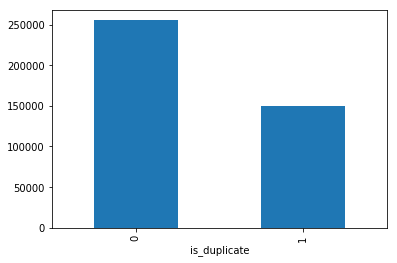

In [405]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [406]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [407]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [408]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values
q_vals

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



array([157, 120, 111, ...,   1,   1,   1], dtype=int64)

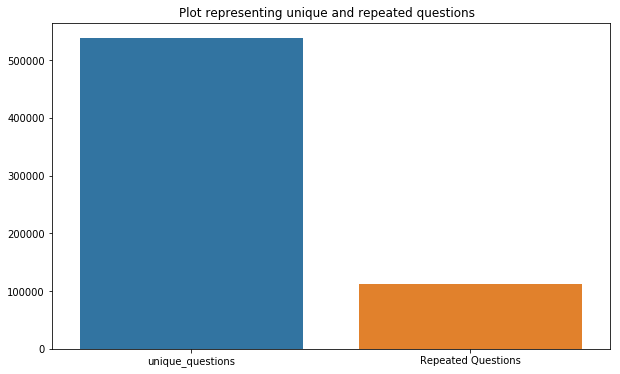

In [409]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [410]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



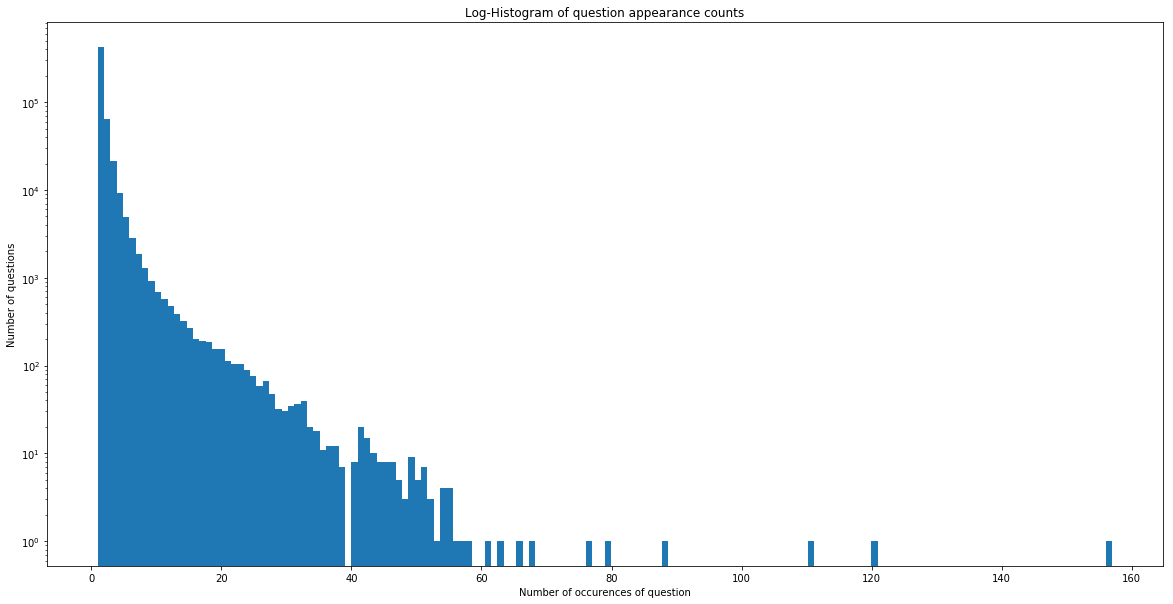

In [411]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [412]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [413]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [414]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0

In [415]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [416]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

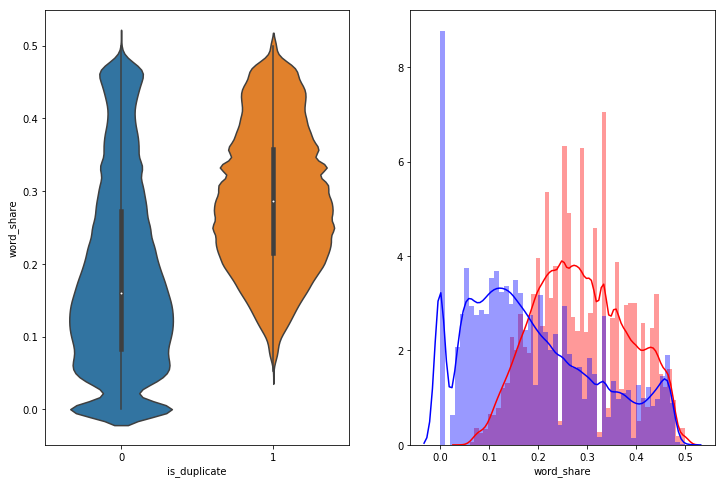

In [417]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

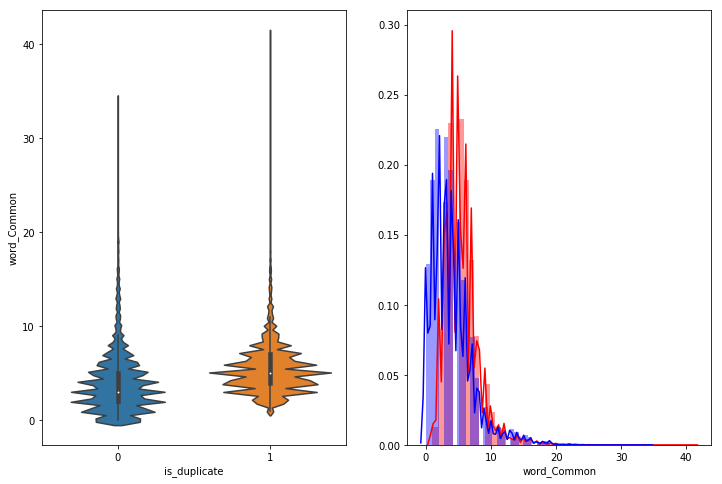

In [418]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping 

### 1.2.1 : EDA: Advanced Feature Extraction.


In [419]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [420]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [421]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [422]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
import nltk
nltk.download('stopwords')

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nrtsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [423]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

# def get_longest_substr_ratio(a, b):
#     strs = list(distance.lcsubstrings(a, b))
#     if len(strs) == 0:
#         return 0
#     else:
#         return len(strs[0]) / (min(len(a), len(b)) + 1)
def get_longest_substr_ratio(string1, string2):
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    return len(answer)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [424]:
# get_longest_substr_ratio("sai mohan","sai ram")

In [425]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100                     6  
1                  75                     5  

[2 rows x 21 columns]

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [426]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ',encoding="utf-8", fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ',encoding="utf-8", fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [427]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


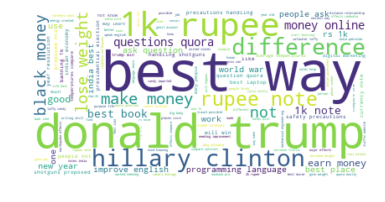

In [428]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


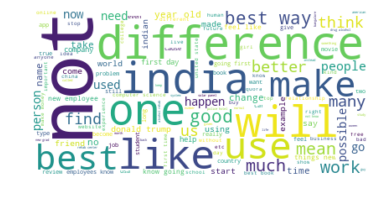

In [429]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

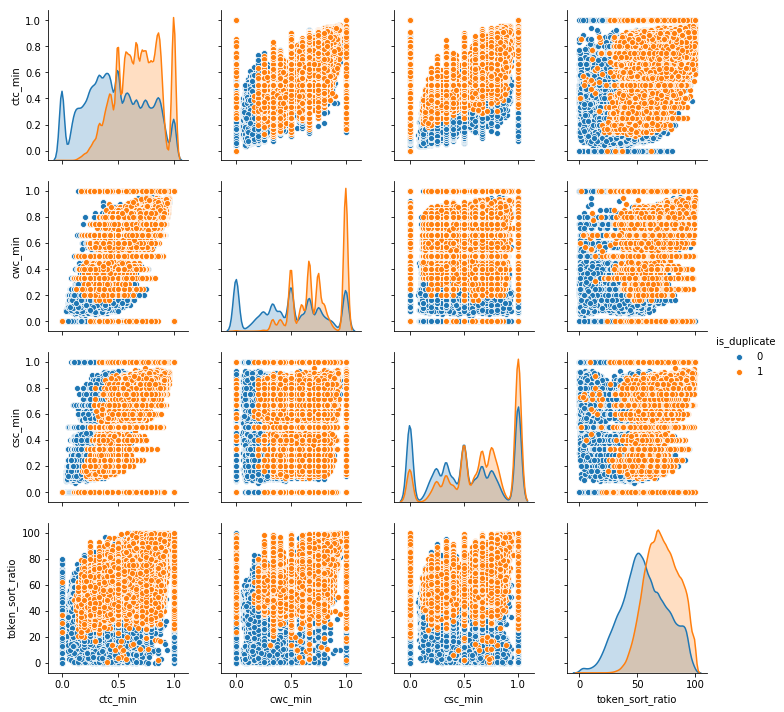

In [430]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

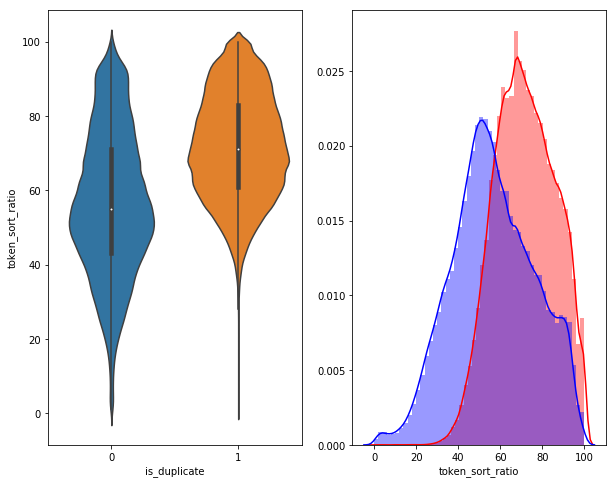

In [431]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

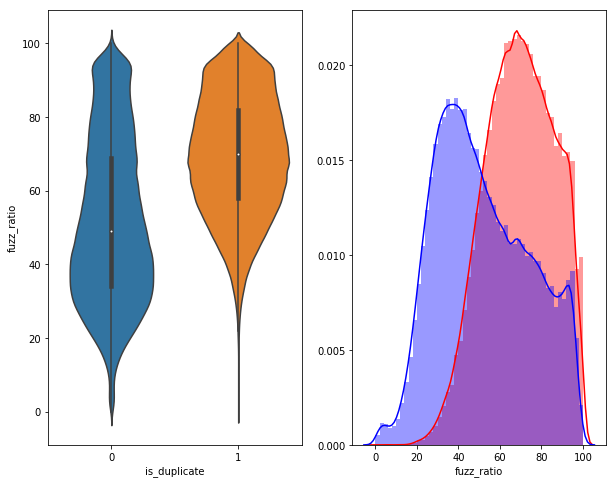

In [432]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [433]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [434]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.125782
[t-SNE] Computed conditional probabilities in 0.228s
[t-SNE] Iteration 50: error = 80.9989243, gradient norm = 0.0434479 (50 iterations in 3.013s)
[t-SNE] Iteration 100: error = 70.3852386, gradient norm = 0.0095453 (50 iterations in 1.991s)
[t-SNE] Iteration 150: error = 68.5403214, gradient norm = 0.0067035 (50 iterations in 2.098s)
[t-SNE] Iteration 200: error = 67.5925217, gradient norm = 0.0044718 (50 iterations in 2.665s)
[t-SNE] Iteration 250: error = 67.0806198, gradient norm = 0.0031985

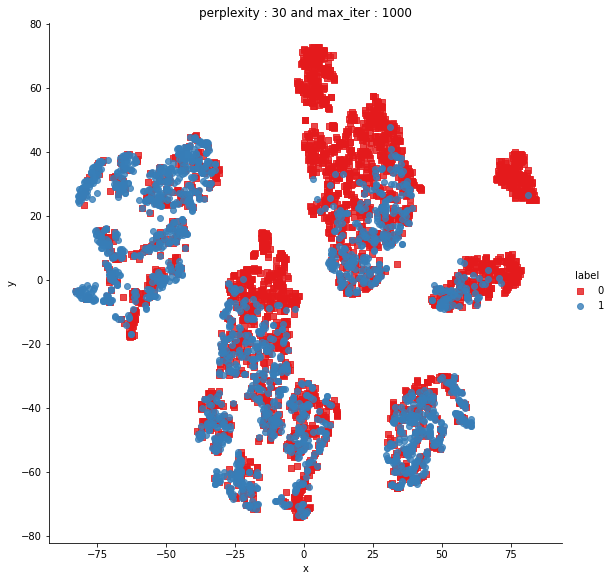

In [435]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [436]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.125782
[t-SNE] Computed conditional probabilities in 0.200s
[t-SNE] Iteration 50: error = 80.3015518, gradient norm = 0.0303549 (50 iterations in 9.245s)
[t-SNE] Iteration 100: error = 68.9446640, gradient norm = 0.0036626 (50 iterations in 4.580s)
[t-SNE] Iteration 150: error = 67.4880295, gradient norm = 0.0016740 (50 iterations in 4.728s)
[t-SNE] Iteration 200: error = 66.9194107, gradient norm = 0.0012291 (50 iterations in 4.442s)
[t-SNE] Iteration 250: error = 66.5958176, gradient norm = 0.0009203

In [437]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [438]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [520]:
# avoid decoding problems
df = pd.read_csv("nlp_features_train.csv")
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))


In [521]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100                     6  
1                  75                     5  

[2 rows x 21 columns]

In [522]:
from sklearn.model_selection import train_test_split
X = df.drop('is_duplicate',axis = 1)
Y = df['is_duplicate']
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.33)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(270874, 20) (270874,)
(133416, 20) (133416,)


In [523]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])
# print(questions)
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [1]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(x_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
#         print(vec1)
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
#             print(idf)
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
#         print(len(mean_vec1))
        
#         print("#####################")
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
# print(len(vecs1))
x_train['q1_feats_m'] = list(vecs1)


In [526]:

train_vecs2 = []
for qu2 in tqdm(list(x_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
#https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean#
    mean_vec2 = mean_vec2.mean(axis=0)
    train_vecs2.append(mean_vec2)
x_train['train_q2_feats_m'] = list(train_vecs2)


  1%|▍                                                                           | 1392/270874 [00:15<51:29, 87.23it/s]


  1%|▋                                                                         | 2666/270874 [00:30<1:04:57, 68.82it/s]


  1%|█                                                                          | 4020/270874 [00:45<36:42, 121.17it/s]


  2%|█▍                                                                         | 5340/270874 [01:01<43:28, 101.79it/s]


  3%|█▉                                                                         | 7069/270874 [01:16<41:57, 104.78it/s]


  3%|██▍                                                                        | 8701/270874 [01:32<39:13, 111.38it/s]


  4%|██▉                                                                        | 10399/270874 [01:47<47:14, 91.90it/s]


  4%|███▎                                                                      | 11983/270874 [02:02<32:50, 131.39it/s]


  5%|███▊                                                                      | 13802/270874 [02:17<34:55, 122.69it/s]


  6%|████▏                                                                    | 15338/270874 [02:32<1:03:26, 67.13it/s]


  6%|████▋                                                                     | 17081/270874 [02:47<33:09, 127.59it/s]


  7%|█████▏                                                                    | 18824/270874 [03:02<32:44, 128.27it/s]


  8%|█████▋                                                                    | 20625/270874 [03:17<34:07, 122.20it/s]


  8%|██████▏                                                                   | 22465/270874 [03:32<32:53, 125.84it/s]


  9%|██████▋                                                                   | 24286/270874 [03:46<33:45, 121.72it/s]


 10%|███████                                                                   | 26079/270874 [04:01<36:02, 113.17it/s]


 10%|███████▌                                                                  | 27799/270874 [04:16<33:50, 119.71it/s]


 11%|████████                                                                  | 29648/270874 [04:31<30:50, 130.33it/s]


 12%|████████▌                                                                 | 31466/270874 [04:46<34:36, 115.32it/s]


 12%|█████████                                                                 | 33325/270874 [05:00<30:14, 130.95it/s]


 13%|█████████▌                                                                | 35025/270874 [05:16<30:19, 129.65it/s]


 14%|██████████                                                                | 36882/270874 [05:30<33:49, 115.28it/s]


 14%|██████████▌                                                               | 38660/270874 [05:45<32:19, 119.75it/s]


 15%|███████████                                                               | 40474/270874 [06:00<29:22, 130.70it/s]


 16%|███████████▌                                                              | 42277/270874 [06:14<33:57, 112.21it/s]


 16%|████████████                                                              | 44083/270874 [06:29<29:57, 126.19it/s]


 17%|████████████▌                                                             | 45968/270874 [06:44<28:51, 129.91it/s]


 18%|█████████████                                                             | 47813/270874 [06:58<32:05, 115.87it/s]


 18%|█████████████▌                                                            | 49628/270874 [07:13<27:38, 133.41it/s]


 19%|██████████████                                                            | 51486/270874 [07:28<28:24, 128.75it/s]


 20%|██████████████▌                                                           | 53385/270874 [07:42<27:43, 130.77it/s]


 20%|███████████████                                                           | 55315/270874 [07:57<26:32, 135.32it/s]


 21%|███████████████▌                                                          | 57150/270874 [08:12<28:21, 125.60it/s]


 22%|████████████████▎                                                          | 58789/270874 [08:27<35:51, 98.56it/s]


 22%|████████████████▌                                                         | 60481/270874 [08:42<30:36, 114.56it/s]


 23%|█████████████████                                                         | 62261/270874 [08:57<26:17, 132.24it/s]


 24%|█████████████████▍                                                        | 63980/270874 [09:12<27:40, 124.58it/s]


 24%|█████████████████▉                                                        | 65660/270874 [09:28<30:38, 111.61it/s]


 25%|██████████████████▋                                                        | 67313/270874 [09:43<34:21, 98.76it/s]


 26%|██████████████████▉                                                       | 69112/270874 [09:57<25:46, 130.43it/s]


 26%|███████████████████▎                                                      | 70876/270874 [10:12<25:11, 132.31it/s]


 27%|███████████████████▉                                                      | 72776/270874 [10:27<24:25, 135.16it/s]


 28%|████████████████████▋                                                      | 74664/270874 [10:42<34:54, 93.69it/s]


 28%|████████████████████▉                                                     | 76440/270874 [10:56<26:06, 124.08it/s]


 29%|█████████████████████▎                                                    | 78198/270874 [11:11<24:38, 130.31it/s]


 29%|█████████████████████▊                                                    | 79855/270874 [11:26<28:55, 110.09it/s]


 30%|██████████████████████▎                                                   | 81545/270874 [11:42<26:42, 118.16it/s]


 31%|███████████████████████                                                    | 83196/270874 [11:57<34:01, 91.92it/s]


 31%|███████████████████████▏                                                  | 84899/270874 [12:12<24:20, 127.35it/s]


 32%|███████████████████████▋                                                  | 86589/270874 [12:27<25:38, 119.75it/s]


 33%|████████████████████████                                                  | 88308/270874 [12:43<23:57, 126.98it/s]


 33%|████████████████████████▌                                                 | 90067/270874 [12:58<23:18, 129.24it/s]


 34%|█████████████████████████                                                 | 91688/270874 [13:13<25:19, 117.89it/s]


 34%|█████████████████████████▌                                                | 93422/270874 [13:28<24:03, 122.95it/s]


 35%|██████████████████████████                                                | 95216/270874 [13:43<22:48, 128.33it/s]


 36%|██████████████████████████▍                                               | 96916/270874 [13:58<23:18, 124.42it/s]


 36%|██████████████████████████▉                                               | 98584/270874 [14:13<26:05, 110.04it/s]


 37%|███████████████████████████                                              | 100398/270874 [14:28<22:39, 125.43it/s]


 38%|███████████████████████████▌                                             | 102227/270874 [14:43<22:58, 122.33it/s]


 38%|████████████████████████████▍                                             | 103957/270874 [14:58<28:27, 97.78it/s]


 39%|████████████████████████████▍                                            | 105560/270874 [15:13<22:58, 119.95it/s]


 40%|████████████████████████████▉                                            | 107315/270874 [15:28<23:13, 117.37it/s]


 40%|█████████████████████████████▊                                            | 108923/270874 [15:43<31:37, 85.35it/s]


 41%|█████████████████████████████▊                                           | 110601/270874 [15:58<20:20, 131.28it/s]


 41%|██████████████████████████████▎                                          | 112396/270874 [16:13<21:56, 120.41it/s]


 42%|███████████████████████████████                                           | 113921/270874 [16:29<41:35, 62.91it/s]


 43%|███████████████████████████████▏                                         | 115669/270874 [16:44<20:25, 126.65it/s]


 43%|███████████████████████████████▋                                         | 117519/270874 [16:58<20:22, 125.44it/s]


 44%|████████████████████████████████▏                                        | 119296/270874 [17:13<22:43, 111.14it/s]


 45%|████████████████████████████████▌                                        | 120949/270874 [17:28<19:18, 129.38it/s]


 45%|█████████████████████████████████                                        | 122828/270874 [17:43<18:48, 131.17it/s]


 46%|█████████████████████████████████▌                                       | 124748/270874 [17:57<18:21, 132.70it/s]


 47%|█████████████████████████████████▋                                      | 126542/270874 [18:13<1:11:46, 33.52it/s]


 47%|██████████████████████████████████▉                                       | 127709/270874 [18:30<25:46, 92.60it/s]


 48%|██████████████████████████████████▊                                      | 129327/270874 [18:45<21:52, 107.85it/s]


 48%|███████████████████████████████████▎                                     | 131063/270874 [19:00<18:34, 125.42it/s]


 49%|███████████████████████████████████▊                                     | 132747/270874 [19:15<22:52, 100.61it/s]


 50%|████████████████████████████████████▋                                     | 134267/270874 [19:31<35:24, 64.30it/s]


 50%|█████████████████████████████████████▏                                    | 135975/270874 [19:46<24:57, 90.07it/s]


 51%|█████████████████████████████████████                                    | 137736/270874 [20:00<16:59, 130.64it/s]


 51%|█████████████████████████████████████▌                                   | 139482/270874 [20:15<19:53, 110.06it/s]


 52%|██████████████████████████████████████▌                                   | 141160/270874 [20:30<26:32, 81.48it/s]


 53%|██████████████████████████████████████▍                                  | 142820/270874 [20:46<20:28, 104.26it/s]


 53%|██████████████████████████████████████▉                                  | 144567/270874 [21:00<16:22, 128.51it/s]


 54%|███████████████████████████████████████▍                                 | 146407/270874 [21:15<17:17, 120.00it/s]


 55%|███████████████████████████████████████▉                                 | 148070/270874 [21:31<18:08, 112.84it/s]


 55%|████████████████████████████████████████▎                                | 149740/270874 [21:46<20:00, 100.90it/s]


 56%|████████████████████████████████████████▊                                | 151436/270874 [22:01<16:40, 119.38it/s]


 57%|█████████████████████████████████████████▎                               | 153210/270874 [22:16<16:25, 119.43it/s]


 57%|██████████████████████████████████████████▎                               | 154761/270874 [22:32<23:02, 83.98it/s]


 58%|██████████████████████████████████████████▋                               | 156279/270874 [22:47<19:27, 98.19it/s]


 58%|██████████████████████████████████████████▌                              | 157954/270874 [23:02<15:05, 124.73it/s]


 59%|███████████████████████████████████████████▌                              | 159646/270874 [23:18<19:58, 92.83it/s]


 60%|███████████████████████████████████████████▍                             | 161268/270874 [23:33<14:41, 124.38it/s]


 60%|███████████████████████████████████████████▉                             | 163026/270874 [23:48<14:49, 121.19it/s]


 61%|████████████████████████████████████████████▍                            | 164854/270874 [24:02<13:17, 132.92it/s]


 61%|████████████████████████████████████████████▉                            | 166524/270874 [24:18<13:28, 129.06it/s]


 62%|█████████████████████████████████████████████▎                           | 168368/270874 [24:32<13:57, 122.32it/s]


 63%|█████████████████████████████████████████████▊                           | 170160/270874 [24:47<12:45, 131.49it/s]


 63%|██████████████████████████████████████████████▉                           | 171886/270874 [25:03<21:28, 76.85it/s]


 64%|███████████████████████████████████████████████▍                          | 173419/270874 [25:18<17:04, 95.15it/s]


 65%|███████████████████████████████████████████████▏                         | 175028/270874 [25:33<11:57, 133.55it/s]


 65%|███████████████████████████████████████████████▋                         | 176827/270874 [25:48<14:03, 111.51it/s]


 66%|████████████████████████████████████████████████                         | 178479/270874 [26:03<13:19, 115.50it/s]


 67%|████████████████████████████████████████████████▌                        | 180161/270874 [26:18<11:23, 132.63it/s]


 67%|█████████████████████████████████████████████████                        | 182000/270874 [26:32<11:28, 129.00it/s]


 68%|█████████████████████████████████████████████████▌                       | 183846/270874 [26:47<11:50, 122.51it/s]


 69%|██████████████████████████████████████████████████                       | 185713/270874 [27:02<13:59, 101.50it/s]


 69%|██████████████████████████████████████████████████▌                      | 187464/270874 [27:17<11:19, 122.73it/s]


 70%|███████████████████████████████████████████████████                      | 189311/270874 [27:31<10:37, 127.94it/s]


 71%|███████████████████████████████████████████████████▌                     | 191214/270874 [27:46<09:44, 136.21it/s]


 71%|████████████████████████████████████████████████████                     | 193037/270874 [28:01<09:57, 130.31it/s]


 72%|████████████████████████████████████████████████████▌                    | 194931/270874 [28:16<11:44, 107.83it/s]


 73%|█████████████████████████████████████████████████████                    | 196750/270874 [28:31<09:24, 131.37it/s]


 73%|█████████████████████████████████████████████████████▌                   | 198583/270874 [28:45<09:16, 129.80it/s]


 74%|██████████████████████████████████████████████████████                   | 200486/270874 [29:00<08:59, 130.48it/s]


 75%|██████████████████████████████████████████████████████▌                  | 202404/270874 [29:14<08:34, 132.98it/s]


 75%|███████████████████████████████████████████████████████                  | 204169/270874 [29:29<08:31, 130.42it/s]


 76%|███████████████████████████████████████████████████████▌                 | 205984/270874 [29:44<08:14, 131.21it/s]


 77%|████████████████████████████████████████████████████████                 | 207882/270874 [29:59<08:12, 127.81it/s]


 77%|████████████████████████████████████████████████████████▌                | 209713/270874 [30:13<07:57, 128.17it/s]


 78%|█████████████████████████████████████████████████████████                | 211608/270874 [30:28<08:30, 116.07it/s]


 79%|█████████████████████████████████████████████████████████▌               | 213496/270874 [30:43<07:09, 133.62it/s]


 80%|██████████████████████████████████████████████████████████               | 215412/270874 [30:57<06:53, 134.01it/s]


 80%|██████████████████████████████████████████████████████████▌              | 217305/270874 [31:12<06:55, 128.97it/s]


 81%|███████████████████████████████████████████████████████████▊              | 218923/270874 [31:27<08:53, 97.35it/s]


 81%|███████████████████████████████████████████████████████████▍             | 220645/270874 [31:42<06:46, 123.64it/s]


 82%|███████████████████████████████████████████████████████████▉             | 222388/270874 [31:57<06:37, 121.94it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 224024/270874 [32:12<09:29, 82.25it/s]


 83%|█████████████████████████████████████████████████████████████▌            | 225282/270874 [32:27<09:43, 78.10it/s]


 84%|█████████████████████████████████████████████████████████████▏           | 226941/270874 [32:42<05:51, 124.90it/s]


 84%|██████████████████████████████████████████████████████████████▍           | 228566/270874 [32:57<07:48, 90.37it/s]


 85%|█████████████████████████████████████████████████████████████▉           | 230046/270874 [33:12<05:19, 127.94it/s]


 86%|██████████████████████████████████████████████████████████████▍          | 231868/270874 [33:27<06:04, 107.10it/s]


 86%|██████████████████████████████████████████████████████████████▉          | 233722/270874 [33:41<05:07, 120.84it/s]


 87%|███████████████████████████████████████████████████████████████▍         | 235487/270874 [33:56<05:39, 104.34it/s]


 88%|███████████████████████████████████████████████████████████████▉         | 237294/270874 [34:11<04:19, 129.24it/s]


 88%|████████████████████████████████████████████████████████████████▍        | 239045/270874 [34:26<04:34, 115.77it/s]


 89%|████████████████████████████████████████████████████████████████▉        | 240818/270874 [34:41<04:16, 116.97it/s]


 90%|█████████████████████████████████████████████████████████████████▍       | 242628/270874 [34:56<04:30, 104.29it/s]


 90%|█████████████████████████████████████████████████████████████████▊       | 244391/270874 [35:11<03:25, 128.57it/s]


 91%|██████████████████████████████████████████████████████████████████▎      | 246252/270874 [35:26<03:02, 134.71it/s]


 92%|██████████████████████████████████████████████████████████████████▊      | 248057/270874 [35:40<02:57, 128.54it/s]


 92%|████████████████████████████████████████████████████████████████████▏     | 249743/270874 [35:56<04:02, 87.10it/s]


 93%|███████████████████████████████████████████████████████████████████▊     | 251468/270874 [36:10<02:33, 126.11it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 253364/270874 [36:25<02:16, 128.04it/s]


 94%|████████████████████████████████████████████████████████████████████▋    | 255080/270874 [36:40<02:28, 106.06it/s]


 95%|█████████████████████████████████████████████████████████████████████▏   | 256697/270874 [36:55<02:18, 102.64it/s]


 95%|██████████████████████████████████████████████████████████████████████▍   | 258062/270874 [37:10<03:09, 67.78it/s]


 96%|██████████████████████████████████████████████████████████████████████▊   | 259358/270874 [37:26<02:13, 86.26it/s]


 96%|███████████████████████████████████████████████████████████████████████▏  | 260698/270874 [37:41<02:11, 77.63it/s]


 97%|███████████████████████████████████████████████████████████████████████▌  | 262178/270874 [37:56<01:33, 92.51it/s]


 97%|████████████████████████████████████████████████████████████████████████  | 263867/270874 [38:12<01:23, 84.12it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 265593/270874 [38:27<00:41, 127.36it/s]


 99%|█████████████████████████████████████████████████████████████████████████ | 267215/270874 [38:42<00:53, 68.82it/s]


 99%|████████████████████████████████████████████████████████████████████████▍| 268896/270874 [38:57<00:16, 121.63it/s]


100%|████████████████████████████████████████████████████████████████████████▉| 270497/270874 [39:12<00:03, 110.93it/s]


100%|█████████████████████████████████████████████████████████████████████████| 270874/270874 [39:17<00:00, 114.91it/s]

In [2]:


# test_vecs1 = []
# # https://github.com/noamraph/tqdm
# # tqdm is used to print the progress bar
# for qu1 in tqdm(list(x_test['question1'])):
#     doc1 = nlp(qu1) 
#     # 384 is the number of dimensions of vectors 
#     mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
#     for word1 in doc1:
#         # word2vec
#         vec1 = word1.vector
#         # fetch df score
#         try:
#             idf = word2tfidf[str(word1)]
#         except:
#             idf = 0
#         # compute final vec
#         mean_vec1 += vec1 * idf
#     mean_vec1 = mean_vec1.mean(axis=0)
#     test_vecs1.append(mean_vec1)
# x_test['test_q1_feats_m'] = list(test_vecs1)

In [528]:

test_vecs2 = []
for qu2 in tqdm(list(x_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    test_vecs2.append(mean_vec2)
x_test['test_q2_feats_m'] = list(test_vecs2)



  1%|█                                                                          | 1846/133416 [00:14<16:40, 131.54it/s]


  3%|██                                                                         | 3715/133416 [00:28<16:50, 128.32it/s]


  4%|███▏                                                                       | 5615/133416 [00:43<16:07, 132.15it/s]


  6%|████▏                                                                      | 7443/133416 [00:58<15:34, 134.83it/s]


  7%|█████▏                                                                     | 9315/133416 [01:12<16:34, 124.74it/s]


  8%|██████▏                                                                   | 11173/133416 [01:27<15:05, 134.97it/s]


 10%|███████▏                                                                  | 12986/133416 [01:42<17:10, 116.89it/s]


 11%|████████                                                                  | 14499/133416 [01:57<15:21, 129.03it/s]


 12%|█████████                                                                 | 16321/133416 [02:12<15:07, 129.03it/s]


 14%|██████████                                                                | 18139/133416 [02:26<15:37, 123.00it/s]


 15%|███████████                                                               | 19978/133416 [02:41<16:16, 116.18it/s]


 16%|████████████                                                              | 21843/133416 [02:56<14:04, 132.07it/s]


 18%|█████████████▏                                                            | 23698/133416 [03:10<14:57, 122.19it/s]


 19%|██████████████                                                            | 25341/133416 [03:25<16:51, 106.85it/s]


 20%|██████████████▉                                                           | 26946/133416 [03:41<15:55, 111.44it/s]


 21%|████████████████                                                           | 28514/133416 [03:56<31:05, 56.23it/s]


 23%|████████████████▉                                                          | 30162/133416 [04:11<28:03, 61.33it/s]


 24%|█████████████████▊                                                         | 31652/133416 [04:27<23:31, 72.08it/s]


 25%|██████████████████▎                                                       | 32999/133416 [04:43<14:27, 115.71it/s]


 26%|███████████████████▍                                                       | 34545/133416 [04:58<21:30, 76.62it/s]


 27%|████████████████████                                                      | 36080/133416 [05:13<14:48, 109.53it/s]


 28%|████████████████████▊                                                     | 37585/133416 [05:29<14:18, 111.65it/s]


 29%|█████████████████████▋                                                    | 39092/133416 [05:44<13:07, 119.82it/s]


 31%|██████████████████████▌                                                   | 40719/133416 [05:59<14:38, 105.54it/s]


 32%|███████████████████████▌                                                  | 42405/133416 [06:14<14:02, 108.01it/s]


 33%|████████████████████████▍                                                 | 44001/133416 [06:29<14:02, 106.08it/s]


 34%|█████████████████████████▎                                                | 45597/133416 [06:44<13:59, 104.63it/s]


 35%|██████████████████████████                                                | 47009/133416 [07:00<11:35, 124.16it/s]


 37%|███████████████████████████                                               | 48727/133416 [07:15<11:16, 125.14it/s]


 38%|████████████████████████████▎                                              | 50386/133416 [07:30<18:03, 76.61it/s]


 39%|████████████████████████████▉                                             | 52109/133416 [07:45<10:40, 126.93it/s]


 40%|█████████████████████████████▉                                            | 53865/133416 [08:00<11:15, 117.85it/s]


 42%|██████████████████████████████▊                                           | 55632/133416 [08:15<12:47, 101.34it/s]


 43%|███████████████████████████████▊                                          | 57341/133416 [08:30<10:14, 123.70it/s]


 44%|████████████████████████████████▋                                         | 59005/133416 [08:45<10:06, 122.70it/s]


 46%|█████████████████████████████████▋                                        | 60791/133416 [09:00<09:43, 124.37it/s]


 47%|██████████████████████████████████▋                                       | 62630/133416 [09:14<09:44, 121.17it/s]


 48%|███████████████████████████████████▋                                      | 64422/133416 [09:29<10:46, 106.76it/s]


 50%|████████████████████████████████████▋                                     | 66139/133416 [09:44<10:17, 108.98it/s]


 50%|█████████████████████████████████████▊                                     | 67217/133416 [10:01<13:07, 84.09it/s]


 51%|██████████████████████████████████████▌                                    | 68499/133416 [10:16<12:10, 88.81it/s]


 52%|██████████████████████████████████████▊                                   | 69924/133416 [10:31<10:09, 104.14it/s]


 53%|████████████████████████████████████████                                   | 71244/133416 [10:48<11:29, 90.19it/s]


 55%|████████████████████████████████████████▉                                  | 72728/133416 [11:03<18:16, 55.36it/s]


 55%|█████████████████████████████████████████                                 | 74034/133416 [11:19<09:43, 101.81it/s]


 57%|██████████████████████████████████████████▍                                | 75512/133416 [11:34<10:15, 94.14it/s]


 58%|██████████████████████████████████████████▊                               | 77185/133416 [11:49<07:41, 121.77it/s]


 59%|███████████████████████████████████████████▋                              | 78736/133416 [12:04<07:44, 117.77it/s]


 60%|████████████████████████████████████████████▌                             | 80329/133416 [12:19<07:45, 114.13it/s]


 61%|██████████████████████████████████████████████                             | 81877/133416 [12:35<09:49, 87.36it/s]


 63%|██████████████████████████████████████████████▎                           | 83393/133416 [12:50<06:48, 122.35it/s]


 64%|███████████████████████████████████████████████                           | 84922/133416 [13:05<07:30, 107.67it/s]


 65%|███████████████████████████████████████████████▉                          | 86511/133416 [13:20<06:52, 113.67it/s]


 66%|████████████████████████████████████████████████▉                         | 88195/133416 [13:35<06:01, 125.13it/s]


 67%|█████████████████████████████████████████████████▊                        | 89808/133416 [13:51<06:44, 107.69it/s]


 68%|██████████████████████████████████████████████████▋                       | 91361/133416 [14:06<06:51, 102.23it/s]


 70%|███████████████████████████████████████████████████▌                      | 92880/133416 [14:21<06:32, 103.17it/s]


 71%|████████████████████████████████████████████████████▍                     | 94553/133416 [14:36<05:36, 115.42it/s]


 72%|██████████████████████████████████████████████████████                     | 96213/133416 [14:51<06:27, 95.94it/s]


 73%|██████████████████████████████████████████████████████▎                   | 97861/133416 [15:06<05:23, 109.89it/s]


 75%|███████████████████████████████████████████████████████▏                  | 99481/133416 [15:21<05:14, 108.01it/s]


 76%|███████████████████████████████████████████████████████▎                 | 101031/133416 [15:36<05:03, 106.64it/s]


 77%|████████████████████████████████████████████████████████▏                | 102737/133416 [15:51<04:30, 113.44it/s]


 78%|█████████████████████████████████████████████████████████                | 104317/133416 [16:06<04:40, 103.64it/s]


 79%|█████████████████████████████████████████████████████████▉               | 105790/133416 [16:22<03:46, 121.84it/s]


 80%|███████████████████████████████████████████████████████████▍              | 107150/133416 [16:38<07:53, 55.42it/s]


 82%|███████████████████████████████████████████████████████████▌             | 108875/133416 [16:52<03:17, 124.38it/s]


 83%|████████████████████████████████████████████████████████████▌            | 110697/133416 [17:07<02:57, 128.33it/s]


 84%|█████████████████████████████████████████████████████████████▍           | 112362/133416 [17:22<03:20, 104.92it/s]


 85%|██████████████████████████████████████████████████████████████▍          | 114021/133416 [17:37<02:43, 118.54it/s]


 87%|████████████████████████████████████████████████████████████████▏         | 115761/133416 [17:52<04:51, 60.49it/s]


 88%|████████████████████████████████████████████████████████████████         | 117053/133416 [18:08<02:29, 109.30it/s]


 89%|█████████████████████████████████████████████████████████████████▋        | 118338/133416 [18:23<02:41, 93.40it/s]


 90%|██████████████████████████████████████████████████████████████████▍       | 119720/133416 [18:39<02:23, 95.30it/s]


 91%|██████████████████████████████████████████████████████████████████▎      | 121273/133416 [18:54<01:48, 112.10it/s]


 92%|███████████████████████████████████████████████████████████████████▏     | 122877/133416 [19:09<01:35, 110.48it/s]


 93%|████████████████████████████████████████████████████████████████████     | 124443/133416 [19:23<01:21, 110.15it/s]


 94%|████████████████████████████████████████████████████████████████████▉    | 125966/133416 [19:38<01:06, 111.89it/s]


 96%|█████████████████████████████████████████████████████████████████████▊   | 127566/133416 [19:53<00:52, 112.18it/s]


 97%|██████████████████████████████████████████████████████████████████████▋  | 129181/133416 [20:08<00:38, 110.30it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 130797/133416 [20:23<00:24, 106.10it/s]


 99%|████████████████████████████████████████████████████████████████████████▍| 132414/133416 [20:37<00:08, 115.98it/s]


100%|█████████████████████████████████████████████████████████████████████████| 133416/133416 [20:47<00:00, 106.95it/s]

In [529]:
#prepro_features_train.csv (Simple Preprocessing Features)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [531]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df1_train,df1_test = train_test_split(df1, test_size = 0.33, shuffle = False, stratify = None)

df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2_train,df2_test = train_test_split(df2, test_size = 0.33, shuffle = False, stratify = None)

df3_q1_train = pd.DataFrame(x_train.q1_feats_m.values.tolist())
df3_q2_train = pd.DataFrame(x_train.train_q2_feats_m.values.tolist())
df3_q1_test = pd.DataFrame(x_test.test_q1_feats_m.values.tolist())
df3_q2_test = pd.DataFrame(x_test.test_q2_feats_m.values.tolist())

In [532]:
print("Number of features in nlp dataframe :", df1_train.shape[1])
print("Number of features in preprocessed dataframe :", df2_train.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1_train.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2_train.shape[1])
print("Number of features in final dataframe  :", df1_train.shape[1]+df2_train.shape[1]+df3_q1_train.shape[1]+df3_q2_train.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [533]:
df3_q1_train.head(2)

0          1          2          3         4          5          6   \
0   3.023413  -8.029970  12.184157  -7.107460 -6.153292   9.780989  -9.811264   
1 -44.672274 -14.324388 -40.748922 -22.665742  8.321651  49.338601  40.352962   

          7          8          9   ...         86         87         88  \
0  13.273625   3.899954  20.247249  ...  12.434419  -4.650375  23.567810   
1  97.052611 -40.100605   8.418569  ...  93.691277 -40.484307  -0.226608   

          89        90         91         92         93         94         95  
0  -5.306352 -4.653425  11.937635 -10.841642 -27.044878 -15.276943  22.400739  
1  53.738683 -2.958864  60.162458  25.138307 -25.353485 -72.922505  65.037660  

[2 rows x 96 columns]

In [534]:
print("Number of features in nlp dataframe :", df1_test.shape[1])
print("Number of features in preprocessed dataframe :", df2_test.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1_test.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2_test.shape[1])
print("Number of features in final dataframe  :", df1_test.shape[1]+df2_test.shape[1]+df3_q1_test.shape[1]+df3_q2_test.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [535]:
df3_q1_train['id']=df1_train['id']
df3_q2_train['id']=df1_train['id']
df1  = df1_train.merge(df2_train, on='id',how='left')
df2  = df3_q1_train.merge(df3_q2_train, on='id',how='left')
result1  = df1.merge(df2, on='id',how='left')

In [536]:
result1.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999980  0.833319  0.999983  0.999983  0.916659   
1   1             0  0.799984  0.399996  0.749981  0.599988  0.699993   
2   2             0  0.399992  0.333328  0.399992  0.249997  0.399996   
3   3             0  0.000000  0.000000  0.000000  0.000000  0.000000   
4   4             0  0.399992  0.199998  0.999950  0.666644  0.571420   

    ctc_max  last_word_eq  first_word_eq  ...        86_y       87_y  \
0  0.785709           0.0            1.0  ...   13.263127 -20.191526   
1  0.466664           0.0            1.0  ...   79.393454 -27.987301   
2  0.285712           0.0            1.0  ...  234.670002 -24.048420   
3  0.000000           0.0            0.0  ...  -17.980885  -6.142430   
4  0.307690           0.0            1.0  ...   47.899687 -24.763533   

         88_y        89_y       90_y       91_y       92_y       93_y  \
0   55.224846   13.280552 -21.085444  30.002980  28.876990 -21.152708   
1   44.666385   55.812295 -18.297997  60.232741 -25.597923 -62.026730   
2  202.564628  204.123222 -16.388463  14.696014 -66.197008  36.229522   
3  113.402322   32.621524 -31.680849 -33.261058  36.306587  47.987705   
4   37.997815   -6.483479 -14.050111  37.105386 -30.773097  -7.292128   

         94_y        95_y  
0  -11.194742    6.089434  
1  -59.961035   69.664718  
2 -168.201258  145.004775  
3  -68.191963    4.450711  
4  -59.052102   26.749532  

[5 rows x 220 columns]

In [537]:
df3_q1_test['id']=df1_test['id']
df3_q2_test['id']=df1_test['id']
df1  = df1_test.merge(df2_test, on='id',how='left')
df2 = pd.concat([df3_q1_test,df3_q2_test], axis = 1)
df2 = df2.drop('id', axis = 1)
result2 = pd.concat([df1,df2], axis=1)
result2 = result2.dropna()
result2.head(2)


id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0  270874             0  0.333322  0.199996  0.499992  0.428565  0.399996   
1  270875             0  0.333328  0.249997  0.249994  0.199996  0.299997   

    ctc_max  last_word_eq  first_word_eq  ...          86         87  \
0  0.363633           0.0            1.0  ...   71.388376 -82.631590   
1  0.187499           0.0            0.0  ...  153.772866 -54.430815   

           88         89         90         91         92         93  \
0  104.041837  19.815929  -2.216038 -21.667213  10.935450  24.544080   
1   49.703788  53.278599 -43.960322   0.208564  10.466991  43.651064   

          94          95  
0 -99.738488   98.384866  
1 -85.953800  112.166261  

[2 rows x 220 columns]

In [538]:
result2.columns = result1.columns

In [539]:
result2.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0  270874             0  0.333322  0.199996  0.499992  0.428565  0.399996   
1  270875             0  0.333328  0.249997  0.249994  0.199996  0.299997   
2  270876             0  0.333328  0.181817  0.555549  0.416663  0.411762   
3  270877             1  0.999980  0.833319  0.999975  0.999975  0.999989   
4  270878             1  0.749981  0.599988  0.666644  0.333328  0.714276   

    ctc_max  last_word_eq  first_word_eq  ...        86_y        87_y  \
0  0.363633           0.0            1.0  ...   71.388376  -82.631590   
1  0.187499           0.0            0.0  ...  153.772866  -54.430815   
2  0.279999           0.0            0.0  ...   37.509828   17.928029   
3  0.899991           0.0            1.0  ...   56.678023   -7.592368   
4  0.454541           0.0            1.0  ...   70.572885  127.682035   

         88_y       89_y        90_y       91_y       92_y       93_y  \
0  104.041837  19.815929   -2.216038 -21.667213  10.935450  24.544080   
1   49.703788  53.278599  -43.960322   0.208564  10.466991  43.651064   
2   68.851448  49.326123   52.459815 -35.894296  31.905552  -1.368714   
3   27.472054 -13.033152  -32.838342  28.237607 -49.572853 -28.705718   
4  185.898762  96.863424 -185.736606   4.623639 -90.732722  -8.424822   

         94_y        95_y  
0  -99.738488   98.384866  
1  -85.953800  112.166261  
2   -7.790792  -39.562892  
3  -44.971293   69.287321  
4 -128.313292   95.792561  

[5 rows x 220 columns]

In [540]:
result1.to_csv('final_features_train.csv')
result2.to_csv('final_features_test.csv')

In [541]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [554]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_train.csv', names=['id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows
360000 rows


In [555]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [556]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [565]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        df_train = pd.read_sql_query("SELECT * From data LIMIT 70001 ;", conn_r)
        conn_r.commit()
        conn_r.close()

In [566]:
# remove the first row 
df_train.drop(df_train.index[0], inplace=True)
y_train = df_train['is_duplicate']
df_train.drop(['id','index','is_duplicate'], axis=1, inplace=True)


In [567]:
df_train.head()

cwc_min              cwc_max             csc_min  \
1   0.999980000399992   0.8333194446759221  0.9999833336111064   
2  0.7999840003199936   0.3999960000399996  0.7499812504687383   
3  0.3999920001599968   0.3333277778703688  0.3999920001599968   
4                 0.0                  0.0                 0.0   
5  0.3999920001599968  0.19999800001999984  0.9999500024998748   

               csc_max             ctc_min              ctc_max last_word_eq  \
1   0.9999833336111064  0.9166590278414348   0.7857086735094749          0.0   
2   0.5999880002399952  0.6999930000699993   0.4666635555762962          0.0   
3  0.24999687503906198  0.3999960000399996  0.28571224491253633          0.0   
4                  0.0                 0.0                  0.0          0.0   
5   0.6666444451851604  0.5714204082798817   0.3076899408466089          0.0   

  first_word_eq abs_len_diff mean_len  ...                 86_y  \
1           1.0          2.0     13.0  ...   13.263126730918884   
2           1.0          5.0     12.5  ...    79.39345400035381   
3           1.0          4.0     12.0  ...   234.67000173777342   
4           0.0          2.0     12.0  ...  -17.980885446071625   
5           1.0          6.0     10.0  ...    47.89968687295914   

                  87_y                88_y                 89_y  \
1  -20.191526174545288   55.22484612464905   13.280551552772522   
2  -27.987301111221313   44.66638469696045   55.812294721603394   
3  -24.048419773578644  202.56462781131268   204.12322199344635   
4    -6.14242959022522  113.40232199430466    32.62152359820902   
5  -24.763532876968384   37.99781507253647  -6.4834794998168945   

                  90_y                 91_y                 92_y  \
1  -21.085443824529648    30.00297999382019   28.876989662647247   
2   -18.29799735546112    60.23274111747742  -25.597923278808594   
3  -16.388462781906128   14.696014285087585   -66.19700837135315   
4  -31.680849313735962  -33.261058419942856    36.30658674240112   
5  -14.050110578536987    37.10538613796234  -30.773096822202206   

                  93_y                 94_y                95_y  
1  -21.152708053588867    -11.1947420835495   6.089433789253235  
2   -62.02672976255417  -59.961034655570984   69.66471847891808  
3   36.229521960020065  -168.20125776529312   145.0047751367092  
4   47.987705290317535   -68.19196271896362   4.450710624456406  
5   -7.292127639055252   -59.05210191011429  26.749532282352448  

[5 rows x 218 columns]

In [568]:
#Creating db file from csv
if not os.path.isfile('test.db'):
    disk_engine = create_engine('sqlite:///test.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_test.csv', names=['id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

180000 rows


In [569]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [570]:
read_db = 'test.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [571]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        df_test = pd.read_sql_query("SELECT * From data LIMIT 30001 ;", conn_r)
        conn_r.commit()
        conn_r.close()

In [572]:
df_test.head()

index      id  is_duplicate             cwc_min              cwc_max  \
0    NaN      id  is_duplicate             cwc_min              cwc_max   
1    1.0  270874             0  0.3333222225925802   0.1999960000799984   
2    2.0  270875             0  0.3333277778703688  0.24999687503906198   
3    3.0  270876             0  0.3333277778703688    0.181816528940646   
4    4.0  270877             1   0.999980000399992   0.8333194446759221   

              csc_min             csc_max             ctc_min  \
0             csc_min             csc_max             ctc_min   
1  0.4999916668055533  0.4285653062099113  0.3999960000399996   
2  0.2499937501562461  0.1999960000799984  0.2999970000299997   
3  0.5555493827846357  0.4166631944733794  0.4117622837512721   
4  0.9999750006249843  0.9999750006249843  0.9999888890123444   

               ctc_max  last_word_eq  ...                86_y  \
0              ctc_max  last_word_eq  ...                86_y   
1    0.363633057881292           0.0  ...   71.38837566971779   
2  0.18749882813232416           0.0  ...  153.77286553382874   
3     0.27999888000448           0.0  ...   37.50982838869095   
4   0.8999910000899991           0.0  ...   56.67802309989929   

                  87_y                88_y                 89_y  \
0                 87_y                88_y                 89_y   
1   -82.63159036636353  104.04183673858643    19.81592893600464   
2  -54.430814838036895   49.70378768444061    53.27859878540039   
3   17.928028792142868   68.85144755244255    49.32612282037735   
4   -7.592367887496948   27.47205352783203  -13.033152222633362   

                  90_y                 91_y                 92_y  \
0                 90_y                 91_y                 92_y   
1   -2.216038016602397  -21.667213439941406   10.935450434684753   
2  -43.960321579128504  0.20856380462646484   10.466991186141968   
3    52.45981514453888   -35.89429569244385   31.905552089214325   
4   -32.83834230899811   28.237606525421143  -49.572853088378906   

                  93_y                 94_y                 95_y  
0                 93_y                 94_y                 95_y  
1    24.54408025741577   -99.73848757147789    98.38486644625664  
2    43.65106439590454   -85.95380041003227    112.1662614941597  
3  -1.3687143325805664  -7.7907915115356445  -39.562891721725464  
4  -28.705718100070953   -44.97129309177399    69.28732132911682  

[5 rows x 221 columns]

In [573]:
# remove the first row 
df_test.drop(df_test.index[0], inplace=True)
y_test = df_test['is_duplicate']
df_test.drop(['id','index','is_duplicate'], axis=1, inplace=True)


<h2> 4.2 Converting strings to numerics </h2>

In [126]:
# https://stackoverflow.com/questions/40790031/pandas-to-numeric-find-out-which-string-it-was-unable-to-parse
# print (data[pd.to_numeric(data.cwc_max, errors='coerce').isnull()])

In [576]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(df_train.columns)
for i in cols:
    df_train[i] = df_train[i].apply(pd.to_numeric)
    
cols = list(df_test.columns)
for i in cols:
    df_test[i] = df_test[i].apply(pd.to_numeric)



In [584]:
# # https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_train = list(map(int, y_train.values))
y_test = list(map(int, y_test.values))

In [592]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [593]:
print(df_train.shape, y_train.shape)
print(df_test.shape, y_test.shape)

(70000, 218) (70000,)
(30000, 218) (30000,)


In [594]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275428571428572 Class 1:  0.3724571428571429
---------- Distribution of output variable in test data ----------
Class 0:  0.6283333333333333 Class 1:  0.37166666666666665


In [595]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## XGBoost

In [598]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
df_train = scale.fit_transform(df_train)
df_test = scale.transform(df_test)

In [614]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
params = {
        'estimators' : [100,200,300,500],
        'depth' : [1,2,3,4,5],
       'learning_rate' : [0.1,0.2,0.3,0.4]

        }
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring= "neg_log_loss", cv = 3, verbose=3)
random_search.fit(df_train,y_train)
optimal_estimators = random_search.best_params_['estimators']
optimal_depth = random_search.best_params_['depth']
optimal_learning_rate = random_search.best_params_['learning_rate']
print("The Optimal number of estimators: ", optimal_estimators)
print("The Optimal depth is ", optimal_depth)
print("The Optimal learning rate is ", optimal_learning_rate)
train_scores = random_search.cv_results_.get('mean_train_score')
test_scores = random_search.cv_results_.get('mean_test_score')
print("Train Scores: ",train_scores)
print("Test Scores: ",test_scores)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, estimators=200, depth=1 ......................
[CV]  learning_rate=0.1, estimators=200, depth=1, score=-0.364, total=  57.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.5s remaining:    0.0s


[CV] learning_rate=0.1, estimators=200, depth=1 ......................
[CV]  learning_rate=0.1, estimators=200, depth=1, score=-0.361, total=  57.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] learning_rate=0.1, estimators=200, depth=1 ......................
[CV]  learning_rate=0.1, estimators=200, depth=1, score=-0.361, total=  55.1s
[CV] learning_rate=0.4, estimators=300, depth=4 ......................
[CV]  learning_rate=0.4, estimators=300, depth=4, score=-0.359, total=  59.3s
[CV] learning_rate=0.4, estimators=300, depth=4 ......................
[CV]  learning_rate=0.4, estimators=300, depth=4, score=-0.358, total=  56.9s
[CV] learning_rate=0.4, estimators=300, depth=4 ......................
[CV]  learning_rate=0.4, estimators=300, depth=4, score=-0.356, total=  59.9s
[CV] learning_rate=0.4, estimators=300, depth=2 ......................
[CV]  learning_rate=0.4, estimators=300, depth=2, score=-0.359, total=  52.2s
[CV] learning_rate=0.4, estimators=300, depth=2 ......................
[CV]  learning_rate=0.4, estimators=300, depth=2, score=-0.358, total=  52.5s
[CV] learning_rate=0.4, estimators=300, depth=2 ......................
[CV]  learning_rate=0.4, estimators

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 26.9min finished


The Optimal number of estimators:  500
The Optimal depth is  5
The Optimal learning rate is  0.3
Train Scores:  None
Test Scores:  [-0.36194366 -0.35757692 -0.35757692 -0.35437017 -0.35437017 -0.35757692
 -0.35415477 -0.35437017 -0.35415477 -0.35415477]


In [616]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = optimal_learning_rate
params['max_depth'] = optimal_depth
params['n_estimators'] = optimal_estimators

d_train = xgb.DMatrix(df_train, label=y_train)
d_test = xgb.DMatrix(df_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(df_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.578589	valid-logloss:0.578973
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.366578	valid-logloss:0.371522
[20]	train-logloss:0.343741	valid-logloss:0.354725
[30]	train-logloss:0.331318	valid-logloss:0.350611
[40]	train-logloss:0.320133	valid-logloss:0.350902
Stopping. Best iteration:
[27]	train-logloss:0.334253	valid-logloss:0.350282

The test log loss is: 0.35142624234456393


Total number of data points : 30000


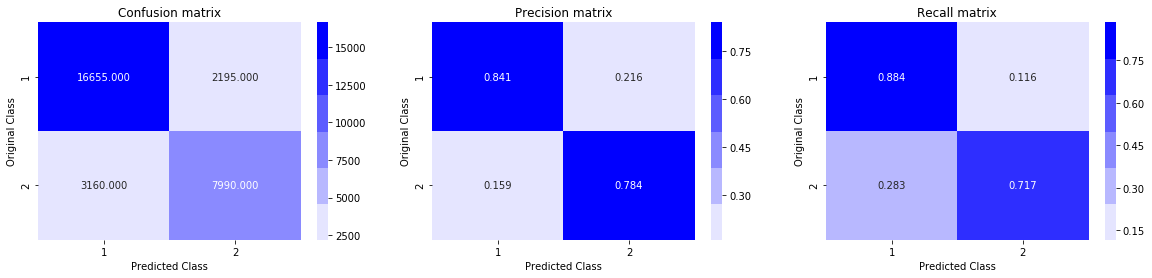

In [617]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression and Linear SVM with Tfidf vectors

In [618]:
# Lets consider only simple features and advanced features(exclude the tfidf weighted W2V)
data.columns[:26]


Index(['index', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total'],
      dtype='object')

In [619]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [620]:

df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)  # Advanced features
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1) # Simple features
df3 = dfnlp[['id','question1','question2']]                                      
Y = dfnlp.is_duplicate

In [621]:
df1.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [622]:
df2.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [623]:
df3.columns

Index(['id', 'question1', 'question2'], dtype='object')

In [624]:
df3 = df3.fillna(' ')
df4 = pd.DataFrame()
df4['Text'] = df3.question1 + ' ' + df3.question2
df4['id'] = df3.id

In [625]:
df4['Text'][0]

'what is the step by step guide to invest in share market in india  what is the step by step guide to invest in share market '

In [626]:
df2['id']=df1['id']
df4['id']=df1['id']
df5  = df1.merge(df2, on='id',how='left')
X  = df5.merge(df4, on='id',how='left')

In [627]:
X.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'Text'],
      dtype='object')

In [628]:
X = X.drop('id',axis=1)
X.shape

(404290, 27)

In [629]:
X = X[:100000]
Y = Y[:100000]


In [630]:
x_train,x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3,random_state=13)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(70000, 27) (70000,)
(30000, 27) (30000,)


In [631]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features= 200000)
x_train_vect = tfidf.fit_transform(x_train.Text)
x_test_vect = tfidf.transform(x_test.Text)
print('No of Tfidf features',len(tfidf.get_feature_names()))

No of Tfidf features 200000


In [635]:

from scipy.sparse import hstack
X_train = hstack((x_train.values,x_train_vect))
X_test = hstack((x_test.values,x_test_vect))

In [636]:
print(X_train.shape)
print(X_test.shape)

(70000, 200026)
(30000, 200026)


In [637]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

## Logistic Regression with hyper parameter tuning

For values of alpha =  1e-05 The log loss is: 0.5912035173809331
For values of alpha =  0.0001 The log loss is: 0.4934059830939898
For values of alpha =  0.001 The log loss is: 0.49463174128012577
For values of alpha =  0.01 The log loss is: 0.48916747808727223
For values of alpha =  0.1 The log loss is: 0.45019804966609106
For values of alpha =  1 The log loss is: 0.4320437441291532
For values of alpha =  10 The log loss is: 0.4327076327005138


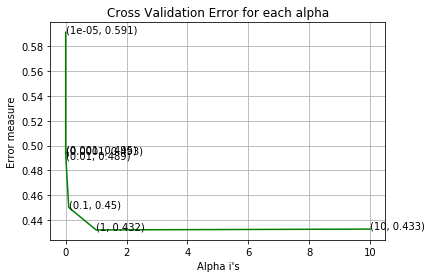

For values of best alpha =  1 The train log loss is: 0.20748558296632427
For values of best alpha =  1 The test log loss is: 0.4320437441291532
Total number of data points : 30000


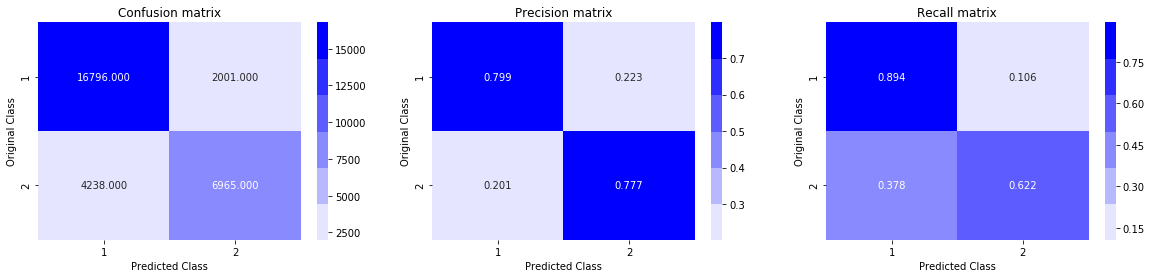

In [640]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight="balanced",alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(class_weight="balanced", alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

The Optimal Value of Alpha is 1

## Linear SVM with hyper parameter tuning

For values of alpha =  1e-05 The log loss is: 0.6607611295678506
For values of alpha =  0.0001 The log loss is: 0.6607611295678506
For values of alpha =  0.001 The log loss is: 0.6607611295678506
For values of alpha =  0.01 The log loss is: 0.6607611295678506
For values of alpha =  0.1 The log loss is: 0.6607611295678506
For values of alpha =  1 The log loss is: 0.6607611295678506
For values of alpha =  10 The log loss is: 0.660763764257134


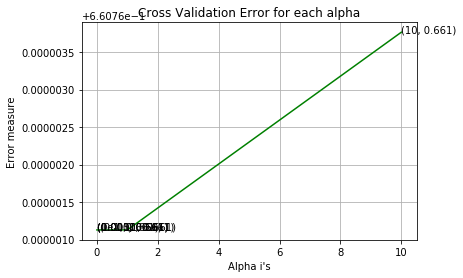

For values of best alpha =  1e-05 The train log loss is: 0.6600937753366309
For values of best alpha =  1e-05 The test log loss is: 0.6607611295678506
Total number of data points : 30000


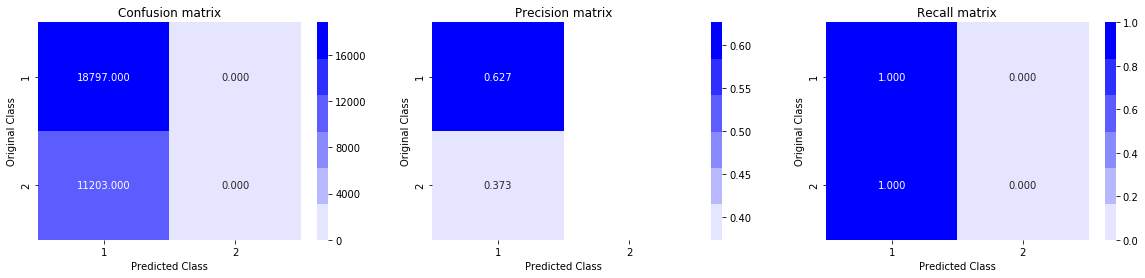

In [643]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight="balanced",alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(class_weight="balanced", alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Complete Procedure

1.Initially done Exploratory Analysis on the given data

2.Basic Feature Extraction (Simple Features)

3.Analysis of Simple features

4.Data Cleaning (Preprocessing of text)

5.Advanced Feature Extraction (Advanced Features)

6.Analysis of Advanced Features

7.At this point, our features are (SF + AF). 

8.Now split the data into train and test sets

9.Now, convert the question into vectors using Tfidf W2V. 

10.Find the Tfidf weighted W2V for both the train and test data

11.Merge these vectors to the other features

12.At this time, both train and test data has (id, is_duplicate, Simple features, Advanced Features, Tfidf W2V for both Q1 and Q2)

13.Convert both the train and test data set into csv files

14.Create database file from CSV's

15.The data from the SQL table is read as string, so convert it into numeric format

16.Then Apply the XGBoost and tune the hyper parameters

18.Now with tfidf features, Apply Linear SVM and Logistic Regression


# Final Observations

In [644]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter","Log loss on Test data"]

x.add_row(["Tfidf W2V", "XGBoost", "learning_rate = 0.3, estimators = 500 & Depth = 5", 0.351])
x.add_row(["TFIDF", "Linear SVM","alpha = 0.00001", 0.66])
x.add_row(["Tfidf", "Logistic Regression", "alpha = 10", 0.43])

print(x)

+------------+---------------------+---------------------------------------------------+-----------------------+
| Vectorizer |        Model        |                  Hyper parameter                  | Log loss on Test data |
+------------+---------------------+---------------------------------------------------+-----------------------+
| Tfidf W2V  |       XGBoost       | learning_rate = 0.3, estimators = 500 & Depth = 5 |         0.351         |
|   TFIDF    |      Linear SVM     |                  alpha = 0.00001                  |          0.66         |
|   Tfidf    | Logistic Regression |                     alpha = 10                    |          0.43         |
+------------+---------------------+---------------------------------------------------+-----------------------+


XGBoost has performed well compared to Linear SVM and Logistic Regression.